In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

from keras.preprocessing import sequence
from keras.preprocessing.text import Tokenizer
from sklearn import preprocessing
from keras.preprocessing import sequence

from keras.models import Sequential
from keras.layers import Dense, Activation, Embedding, SpatialDropout1D, MaxPooling1D, Embedding, Conv1D, Flatten, Dropout
from keras.layers import Bidirectional, GlobalMaxPool1D, LSTM
from keras.optimizers import Adam
from sklearn.utils import shuffle
from sklearn.metrics import f1_score, confusion_matrix


# load data
input_file = "imdb_master.csv"

# comma delimited is the default
data = pd.read_csv(input_file, header = 0, encoding='ISO-8859-1', engine='python')

Using TensorFlow backend.


In [2]:
# show data
data.head()

,Unnamed: 0,type,review,label,file
0,0,test,Once again Mr. Costner has dragged out a movie...,neg,0_2.txt
1,1,test,This is an example of why the majority of acti...,neg,10000_4.txt
2,2,test,"First of all I hate those moronic rappers, who...",neg,10001_1.txt
3,3,test,Not even the Beatles could write songs everyon...,neg,10002_3.txt
4,4,test,Brass pictures (movies is not a fitting word f...,neg,10003_3.txt


In [0]:
# we will divide data on train and test sets

indexes_train = np.where(data['type'] == 'train')
indexes_test = np.where(data['type'] == 'test')

X_train = data['review'][indexes_train[0]].values
Y_train = data['label'][indexes_train[0]].values

X_test = data['review'][indexes_test[0]].values
Y_test = data['label'][indexes_test[0]].values


In [0]:
# certain indices of positive and negative reviews

index_unsup = np.where(Y_train == 'unsup')
Y_train = np.delete(Y_train, index_unsup)
X_train = np.delete(X_train, index_unsup)

In [5]:
# example review
data['review'][55000]

'When the comedy channel comes out with content like this, it makes me wonder why the Canadian government forces channels to have Canadian content. Because that is the only explanation as to why this show ever existed... As filler to appease the law so the Comedy channel would have "Canadian" shows on.<br /><br />Frankly the writers are probably the worst in the history of television. If I could send them an open letter, it would beg them to retire immediately and move to Slovenia where the locals might find their off-topic humour funny.<br /><br />The case is even worse too. Elvira Kurt is painful as the host, standing there saying line one liners and praying for the audience to laugh. She should never return to television in any way shape or form. In fact, she should be the one paddling the boat of writers to Slovenia. The rest of the case should swim alongside it, because they don\'t even deserve a seat in the boat.<br /><br />Bad, no name guests, bad questions, bad casting, bad wri

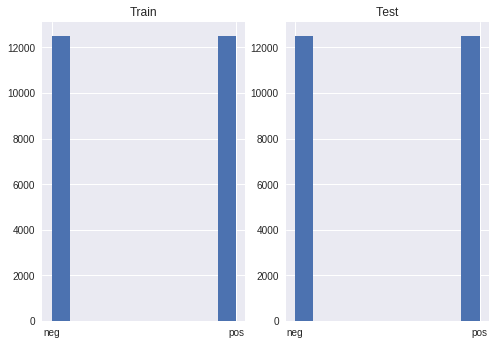

In [6]:
# Analysis of the test and training sample

def buil_hist(data):
    lenf_data = []
    for i in data:
        lenf_data.append(i)
    return lenf_data
    
lenf_train = buil_hist(Y_train)
lenf_test = buil_hist(Y_test)   

plt.subplot(1, 2, 1)
plt.title('Train')
plt.hist(lenf_train)
plt.subplot(1, 2, 2)
plt.hist(lenf_test)
plt.title('Test')
plt.show()


In [7]:
# transform catecorical labels in num labels
le = preprocessing.LabelEncoder()
le.fit(Y_train)

print('Lisr unique labels: {}'.format(le.classes_))

Y_train_encod = le.transform(Y_train) 
Y_test_encod = le.transform(Y_test) 

# inverse transform
# list(le.inverse_transform(Y_test_encod))

# shufle train data set
X_train, Y_train_encod = shuffle(X_train, Y_train_encod)

# check a shuffle
print(Y_train_encod[10], '\n', X_train[10])

Lisr unique labels: ['neg' 'pos']
0 
 Now, I won't deny that when I purchased this off eBay, I had high expectations. This was an incredible out-of-print work from the master of comedy that I so enjoy. However, I was soon to be disappointed. Apologies to those who enjoyed it, but I just found the Compleat Al to be very difficult to watch. I got a few smiles, sure, but the majority of the funny came from the music videos (which I've got on DVD) and the rest was basically filler. You could tell that this was not Al's greatest video achievement (that honor goes to UHF). Honestly, I doubt if this will ever make the jump to DVD, so if you're an ultra-hardcore Al fan and just HAVE to own everything, buy the tape off eBay. Just don't pay too much for it.


In [8]:
# HYPERPARAMETERS
max_features = 10000
maxlen = 100
embedding_dimenssion = 100

VALIDATION_SPLIT = 0.1
CLASSES = 1
NB_EPOCH = 20
BATCH_SIZE = 64
OPTIMIZER = Adam(lr=0.001)

# Tokenization and encoding text corpus
tk = Tokenizer(num_words=max_features)
tk.fit_on_texts(X_train)
X_train_en = tk.texts_to_sequences(X_train)
X_test_en = tk.texts_to_sequences(X_test)

# dictionaries
word2index = tk.word_index
index2word = tk.index_word

Instructions for updating:
Colocations handled automatically by placer.


In [9]:
# check the correctness of the encoding
print('Orginal \n{}'.format(X_train[2]))

print('\nDecoding')
for index in X_train_en[2]:
    x = index2word.get(index)
    print(x, end=' ')
input('\nПроверка верности кодировки. Нажми продолжить для продолжения')

Orginal 
Revolutions always present opportunities for dramatic films since, in fact, most revolutions are in themselves dramatic events. Unfortunately, what this film lacks in drama is compensated for by an overabundance of boredom. One cares not who wins, loses, dies or lives--just end it as soon as possible. This is due in large measure to what seems to me to be a superficial use of background technology. Scenes of Paris and the French countryside have a cardboard quality about them. They might better be done on a bare stage and left that way. One cannot expect the amazing effects of "The House of the Flying Daggers" or "The Golden Compass," but , after all, this is a 2002 digitally mastered production. Characters seem to enter a scene for the sake of entering a scene, so much so that one loses count of the number of times character enter and leave rooms. In my view, this film turns the French Revolution of the 1790s into the "papier-mache" revolution of a "papier colle" world.

Deco

''

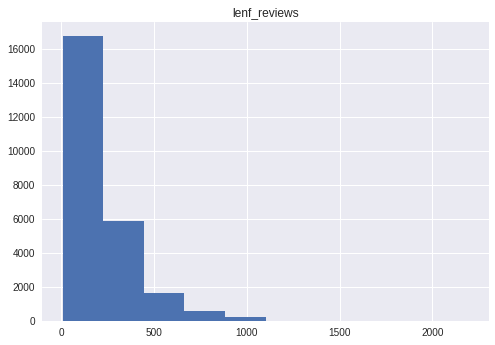

In [10]:
# Аnalysis of the length of each review
lenf_reviews = list(map(len, X_train_en))

plt.hist(lenf_reviews)
plt.title('lenf_reviews')
plt.show()


In [11]:
# import os
# os.listdir('../../../___In_works/Glove')

# we give feedback to the same dimension
X_train_new = sequence.pad_sequences(X_train_en, maxlen=maxlen)
X_test_new = sequence.pad_sequences(X_test_en, maxlen=maxlen)
input('\nLed examples of texts to the general dimension. Click continue to continue')

# path to the pre-trained word vectors or download the link
# https://nlp.stanford.edu/projects/glove/
glove_dir = ''.join(['../../../___In_works/Glove/glove.6B.', str(embedding_dimenssion),'d.txt']) # This is the folder with the dataset

embeddings_index = {} # We create a dictionary of word -> embedding

with open(glove_dir, encoding='utf-8') as f:
    for line in f:
        values = line.split()
        word = values[0] # The first value is the word, the rest are the values of the embedding
        embedding = np.asarray(values[1:], dtype='float32') # Load embedding
        embeddings_index[word] = embedding # Add embedding to our embedding dictionary

print('Found {:,} word vectors in GloVe.'.format(len(embeddings_index)))
input('\nLoaded the pre-trained word vectors in English: Click continue to continue')


Led examples of texts to the general dimension. Click continue to continue
Found 400,000 word vectors in GloVe.

Loaded the pre-trained word vectors in English: Click continue to continue


''

In [12]:
embedding_matrix = np.zeros((max_features, embedding_dimenssion))

# The vectors need to be in the same position as their index.
# Meaning a word with token 1 needs to be in the second row (rows start with zero) and so on

# Loop over all words in the word index
for word, i in word2index.items():
    # If we are above the amount of words we want to use we do nothing
    if i >= max_features:
        break
    # Get the embedding vector for the word
    embedding_vector = embeddings_index.get(word)
    # If there is an embedding vector, put it in the embedding matrix
    if embedding_vector is not None:
        embedding_matrix[i] = embedding_vector
input('Creating your own dictionary of word vectors from Glove is over. Click continue.')

Creating your own dictionary of word vectors from Glove is over. Click continue.


''

In [13]:
# checking the dimension of arrays
print(embedding_matrix.shape, X_train_new.shape, Y_train_encod.shape, X_test_new.shape, Y_test_encod.shape)

(10000, 100) (25000, 100) (25000,) (25000, 100) (25000,)


In [22]:
input('Click continue to learn the model')

model = Sequential()

# LSTM version 1
model.add(Embedding(max_features, embedding_dimenssion, input_length=maxlen,
                    weights=[embedding_matrix], trainable=False))
model.add(LSTM(125, dropout=0.2, recurrent_dropout=0.2))
model.add(Dense(1, activation="sigmoid"))
model.summary()


# compile the model

model.compile(loss='binary_crossentropy', optimizer=OPTIMIZER, metrics=['accuracy'])

# train model
model.fit(X_train_new, Y_train_encod, batch_size=BATCH_SIZE, epochs=10, validation_split=VALIDATION_SPLIT, verbose=1)

# evaluate the quality of the system using accuracy
scores = model.evaluate(X_test_new, Y_test_encod)
print('losses: {}'.format(scores[0]))
print('TEST accuracy: {}'.format(scores[1]))

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding_6 (Embedding)      (None, 100, 100)          1000000   
_________________________________________________________________
lstm_4 (LSTM)                (None, 125)               113000    
_________________________________________________________________
dense_9 (Dense)              (None, 1)                 126       
Total params: 1,113,126
Trainable params: 113,126
Non-trainable params: 1,000,000
_________________________________________________________________
Train on 22500 samples, validate on 2500 samples
Epoch 1/10
22500/22500 [==============================] - 100s 4ms/step - loss: 0.5270 - acc: 0.7237 - val_loss: 0.4175 - val_acc: 0.7980
Epoch 2/10
22500/22500 [==============================] - 97s 4ms/step - loss: 0.4122 - acc: 0.8087 - val_loss: 0.3898 - val_acc: 0.8284
Epoch 3/10
22500/22500 [==============================] - 103s 5ms

In [18]:
input('Click continue to learn the model')

model = Sequential()

# LSTM version 2
model.add(Embedding(max_features, embedding_dimenssion, input_length=maxlen,
                    weights=[embedding_matrix], trainable=False))
model.add(SpatialDropout1D(0.2))
model.add(Bidirectional(LSTM(32, return_sequences = True)))
model.add(GlobalMaxPool1D())
model.add(Dense(20, activation="relu"))
model.add(Dropout(0.05))
model.add(Dense(1, activation="sigmoid"))
model.summary()

# compile the model

model.compile(loss='binary_crossentropy', optimizer=OPTIMIZER, metrics=['accuracy'])

# train model
model.fit(X_train_new, Y_train_encod, batch_size=BATCH_SIZE, epochs=10, validation_split=VALIDATION_SPLIT, verbose=1)

# evaluate the quality of the system using accuracy
scores = model.evaluate(X_test_new, Y_test_encod)
print('losses: {}'.format(scores[0]))
print('TEST accuracy: {}'.format(scores[1]))


Click continue to learn the model
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding_5 (Embedding)      (None, 100, 100)          1000000   
_________________________________________________________________
spatial_dropout1d_3 (Spatial (None, 100, 100)          0         
_________________________________________________________________
bidirectional_3 (Bidirection (None, 100, 64)           34048     
_________________________________________________________________
global_max_pooling1d_3 (Glob (None, 64)                0         
_________________________________________________________________
dense_7 (Dense)              (None, 20)                1300      
_________________________________________________________________
dropout_5 (Dropout)          (None, 20)                0         
_________________________________________________________________
dense_8 (Dense)              (None, 1)    

In [0]:
# predicted labels on test
Y_predicted_test = model.predict_classes(X_test_new)

In [21]:
# evaluate the quality of the system using f1-score and confusion matrix
print('F1-score: {0}'.format(f1_score(Y_predicted_test, Y_test_encod)))
print('Confusion matrix:')
confusion_matrix(Y_predicted_test, Y_test_encod)

F1-score: 0.8601621642393268
Confusion matrix:


array([[10169,  1308],
       [ 2331, 11192]])